In [1]:
import os
import sys
import time
import math


import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.init as init

from torchsummary import summary


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_statistics = (
    (0.49139968, 0.48215827, 0.44653124),
     (0.24703233, 0.24348505, 0.26158768)
) # Mean, Standard Deviation of CIFAR-10 dataset channels


In [20]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

train_transforms = transforms.Compose([
    # Transforms that operate on PIL Images
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),

    # Convert to tensor (must come before tensor operations)
    transforms.ToTensor(),

    # Transforms that operate on tensors
    transforms.Normalize(mean, std, inplace=True),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [23]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data/', download=True, train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
train_batch_size = 128
test_batch_size = 100

train_dl = DataLoader(train_dataset, train_batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, test_batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [24]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm_images = denormalize(images, *data_statistics)
    ax.imshow(make_grid(denorm_images[:64], 8).permute(1, 2, 0))
    break

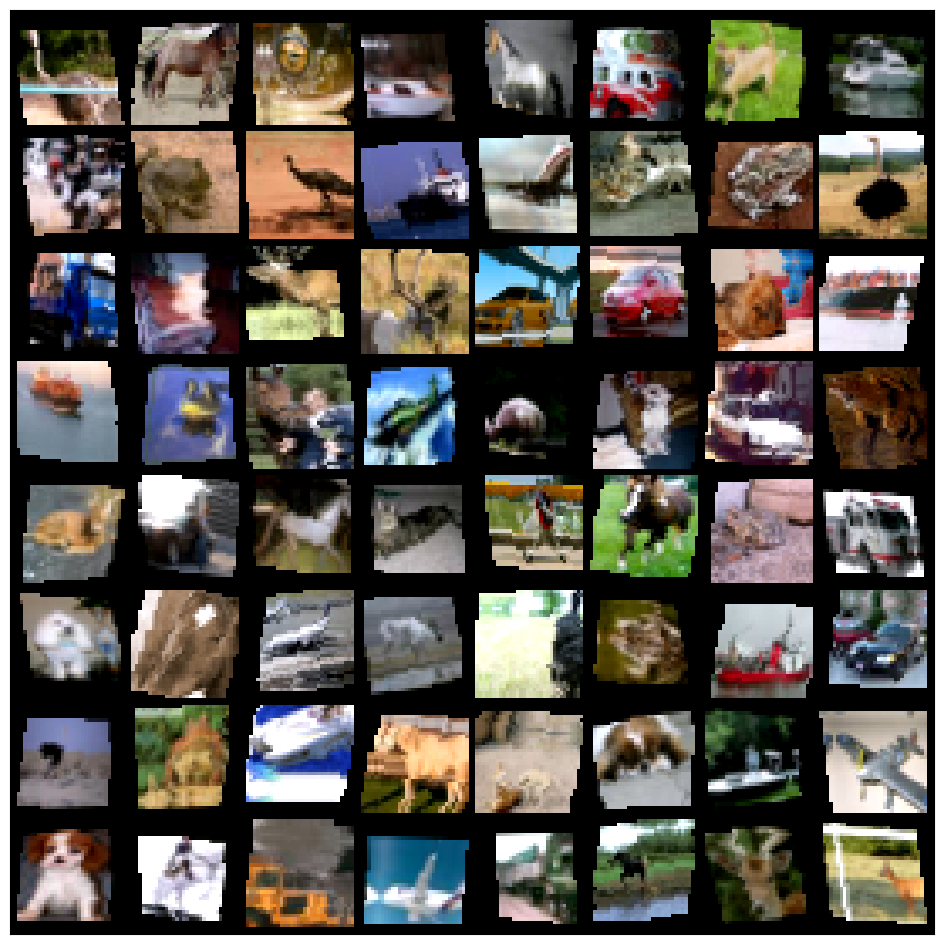

In [26]:
show_batch(train_dl)

In [ ]:
def get_default_device():
  # Pick GPU, if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  # Move tensors to chosen device
  if isinstance(data, (list, tuple)):
    # If the instance is a list/tuple, transfer each element to chosen device
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  # non_blocking=True doesn't block the execution of the host device until transfers complete

class DeviceDataLoader():
  # Wrap a dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [ ]:
# Get the default device
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, reduction=16):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # SE Block
        self.se = SEBlock(planes, reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)  # Apply SE block
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 44

        # Initial convolution with more channels
        self.conv1 = nn.Conv2d(3, 44, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(44)

        # Adjusted channel progression
        self.layer1 = self._make_layer(block, 42, layers[0], stride=1)    # 42 (was 44)
        self.layer2 = self._make_layer(block, 84, layers[1], stride=2)    # 84 (was 88)
        self.layer3 = self._make_layer(block, 152, layers[2], stride=2)   # 152 (was 160)
        self.layer4 = self._make_layer(block, 184, layers[3], stride=2)   # 184 (was 192)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)
        # Fix: Use the correct input size for the FC layer (184 * block.expansion)
        self.fc = nn.Linear(184 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


# ResNet with SE Blocks
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=12):  # Changed from 16 to 12
        super(SEBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        return x * self.fc(x)


def resnet34_light(num_classes=10, dropout_rate=0.5):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, dropout_rate=dropout_rate)

if __name__ == "__main__":
    model = resnet34_light(num_classes=10, dropout_rate=0.5)
    print(model)
    summary(model.cuda(), (3, 32, 32))

ResNet(
  (conv1): Conv2d(3, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(44, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (fc): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(42, 2, kernel_size=(1, 1), stride=(1, 1))
          (2): ReLU()
          (3): Conv2d(2, 42, kernel_size=(1, 1), stride=(1, 1))
          (4): Sigmoid()
        )
      )
      (shortcut): Sequential(
        (0): Conv2d(44, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [ ]:
model =  model.to(device)
if device == 'cuda':
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

In [ ]:
r = 0.1

start_epoch = 1
number_of_epochs = 150
best_acc = 0

# Training Setup
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)



In [ ]:
# Learning Rate Scheduler (Warmup + Cosine Annealing)
warmup_epochs = 5
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200 - warmup_epochs)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])


In [ ]:
import time

def format_time(seconds):
    """Convert seconds to a readable format (hh:mm:ss)."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

In [ ]:
#RICAP Implimentation
use_ricap = False
def ricap(images, targets, beta=0.3):
    # Get batch size
    batch_size = images.size(0)
    height, width = images.size(2), images.size(3)

    # Generate random bounding boxes
    w = int(np.round(width * np.random.beta(beta, beta)))
    h = int(np.round(height * np.random.beta(beta, beta)))
    w_ = [w, width - w, w, width - w]
    h_ = [h, h, height - h, height - h]

    # Select four random images
    cropped_images = {}
    c_ = {}
    W_ = {}
    for k in range(4):
        idx = torch.randperm(batch_size)
        x_k = np.random.randint(0, width - w_[k] + 1)
        y_k = np.random.randint(0, height - h_[k] + 1)
        cropped_images[k] = images[idx][:, :, y_k:y_k + h_[k], x_k:x_k + w_[k]]
        c_[k] = targets[idx].clone()
        W_[k] = (h_[k] * w_[k]) / (height * width)

    # Patch the images
    patched_images = torch.zeros_like(images)
    patched_images[:, :, :h, :w] = cropped_images[0]
    patched_images[:, :, :h, w:] = cropped_images[1]
    patched_images[:, :, h:, :w] = cropped_images[2]
    patched_images[:, :, h:, w:] = cropped_images[3]

    # Return patched images, target lists, and weights
    return patched_images, [c_[0], c_[1], c_[2], c_[3]], W_


In [ ]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    start_time = time.time()

    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_dl):
        # Move inputs and targets to the same device as the model
        inputs, targets = inputs.to(device), targets.to(device)

        # RICAP implementation
        if use_ricap:
            inputs, targets_a, W_ = ricap(inputs, targets, beta=0.3)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)

            # RICAP loss calculation
            loss = 0
            for k in range(4):
                loss += W_[k] * criterion(outputs, targets_a[k])
        else:
            # Standard training
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)

        # For accuracy calculation with RICAP, we use the original targets
        # This is a simplification - with RICAP you might want to use the dominant label
        correct += predicted.eq(targets).sum().item()

    cur_time = time.time()
    epoch_time = cur_time - start_time
    print(f"Training Time : {format_time(epoch_time)}")

    return train_loss/(batch_idx+1), 100.*correct/total, get_lr(optimizer)

def test(epoch):
  global best_acc
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dl):
      # Move inputs and targets to the same device as the model
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  # Save checkpoint.
  acc = 100.*correct/total
  if acc > best_acc:
    print('Saving..')
    state = {
        'net': model.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
    torch.save(state, './checkpoint/resnet_34_dropout_best.pth')
    best_acc = acc

  return test_loss/(batch_idx+1), 100.*correct/total


In [ ]:
def get_lr(optimizer):
    """Retrieve the current learning rate from the optimizer."""
    for param_group in optimizer.param_groups:
        return param_group['lr']  # Return the learning rate of the first param group


In [ ]:
train_losses = []
train_accuracies = []
train_lrs = []

test_losses = []
test_accuracies = []

for epoch in range(start_epoch, start_epoch + number_of_epochs):
  epoch_train_loss, epoch_train_accuracy, epoch_lr = train(epoch)
  train_losses.append(epoch_train_loss)
  train_accuracies.append(epoch_train_accuracy)
  train_lrs.append(epoch_lr)

  epoch_test_loss, epoch_test_accuracy = test(epoch)
  test_losses.append(epoch_test_loss)
  test_accuracies.append(epoch_test_accuracy)

  scheduler.step()
  print(f"Train Loss: {epoch_train_loss:.3f} | Train Accuracy: {epoch_train_accuracy:.3f}% | Test Loss: {epoch_test_loss:.3f} | Test Accuracy: {epoch_test_accuracy:.3f}%")


Epoch: 1
Training Time : 00:02:25
Saving..
Train Loss: 2.145 | Train Accuracy: 9.918% | Test Loss: 1.802 | Test Accuracy: 33.240%

Epoch: 2
Training Time : 00:02:24
Saving..
Train Loss: 2.083 | Train Accuracy: 10.036% | Test Loss: 1.722 | Test Accuracy: 38.960%

Epoch: 3
Training Time : 00:02:22
Saving..
Train Loss: 2.038 | Train Accuracy: 10.046% | Test Loss: 1.509 | Test Accuracy: 50.210%

Epoch: 4


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training Time : 00:02:24
Train Loss: 1.987 | Train Accuracy: 9.906% | Test Loss: 1.550 | Test Accuracy: 45.930%

Epoch: 5
Training Time : 00:02:24
Train Loss: 1.967 | Train Accuracy: 9.954% | Test Loss: 1.497 | Test Accuracy: 50.070%

Epoch: 6
Training Time : 00:02:25
Train Loss: 1.938 | Train Accuracy: 10.070% | Test Loss: 1.484 | Test Accuracy: 50.020%

Epoch: 7
Training Time : 00:02:23
Saving..
Train Loss: 1.918 | Train Accuracy: 9.974% | Test Loss: 1.465 | Test Accuracy: 52.780%

Epoch: 8
Training Time : 00:02:25
Saving..
Train Loss: 1.897 | Train Accuracy: 10.078% | Test Loss: 1.309 | Test Accuracy: 58.690%

Epoch: 9
Training Time : 00:02:25
Saving..
Train Loss: 1.874 | Train Accuracy: 10.068% | Test Loss: 1.264 | Test Accuracy: 61.090%

Epoch: 10
Training Time : 00:02:24
Train Loss: 1.868 | Train Accuracy: 10.420% | Test Loss: 1.314 | Test Accuracy: 60.560%

Epoch: 11
Training Time : 00:02:23
Saving..
Train Loss: 1.858 | Train Accuracy: 10.250% | Test Loss: 1.222 | Test Accuracy:

In [ ]:
# At the end of training (after the loop)
torch.save(model.state_dict(), 'final_model.pth')


In [ ]:
import pickle
import numpy as np
import torch
def load_custom_test_set(filepath):
    # Open the pickle file and load the data
    with open(filepath, 'rb') as f:
        data = pickle.load(f, encoding='bytes')

    # Extract image data
    images = data[b'data']  # Shape: (10000, 32, 32, 3)

    # Fix Shape: Convert (32, 32, 3) → (3, 32, 32)
    images = np.transpose(images, (0, 3, 1, 2))  # New shape: (10000, 3, 32, 32)

    # Convert data to float32
    images = images.astype(np.float32) / 255.0  # Normalize to [0,1]

    # Convert to a PyTorch tensor
    images = torch.tensor(images, dtype=torch.float32)

    return images

# Load test images from the provided file path.
test_images = load_custom_test_set("/content/cifar_test_nolabel.pkl")
print("Loaded custom test set with shape:", test_images.shape)  # e.g., (10000, 3, 32, 32)


Loaded custom test set with shape: torch.Size([10000, 3, 32, 32])


In [ ]:
pkl_mean = [0.513, 0.497, 0.462]
pkl_std = [0.263, 0.260, 0.273]

normalize = transforms.Normalize(mean=pkl_mean, std=pkl_std)

def preprocess_images(images):
    # Loop over each image to apply normalization
    for i in range(images.shape[0]):
        images[i] = normalize(images[i])
    return images

test_images = preprocess_images(test_images)

In [ ]:
test_dataset = torch.utils.data.TensorDataset(test_images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 40

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 40, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(40)

        # Optimized channel progression
        self.layer1 = self._make_layer(block, 40, layers[0], stride=1)    # 40
        self.layer2 = self._make_layer(block, 80, layers[1], stride=2)    # 80
        self.layer3 = self._make_layer(block, 144, layers[2], stride=2)   # 144 (was 160)
        self.layer4 = self._make_layer(block, 176, layers[3], stride=2)   # 176 (was 192)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(176 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def resnet34_light(num_classes=10, dropout_rate=0.5):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, dropout_rate=dropout_rate)


# Instantiate the correct model architecture
model = resnet34_light(num_classes=10, dropout_rate=0.5).to(device)

weights_path = "/content/final_model.pth"  # adjust this if your weights file has a different name
if os.path.exists(weights_path):
    # Load the state dictionary
    state_dict = torch.load(weights_path, map_location=device)

    # Load the state dictionary into the model
    model.load_state_dict(state_dict)
    print("Loaded model weights from", weights_path)
else:
    print("Weights file not found. Using the current model in memory.")

model.eval()

Loaded model weights from /content/final_model.pth


<ipython-input-23-9dd429a8b363>:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


ResNet(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=

In [ ]:
import os
weights_path = "/content/final_model.pth"  # adjust this if your weights file has a different name
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print("Loaded model weights from", weights_path)
else:
    print("Weights file not found. Using the current model in memory.")

model.eval()

Loaded model weights from /content/final_model.pth


<ipython-input-24-f8b426cad1fa>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


ResNet(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=

In [ ]:
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())

In [ ]:
import pandas as pd
from google.colab import files

submission = pd.DataFrame({
    'ID': np.arange(len(all_predictions)),
    'Labels': all_predictions
})

submission.to_csv('submission_v4.csv', index=False)
files.download('submission_v4.csv')  # This will trigger a download to your local system
print("Submission file saved and ready to be downloaded.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Submission file saved and ready to be downloaded.
